In the Data folder file I showed that t>20 basically corresponds to noise. Here I want to check if the network performance improves if I throw out this noise.

In [2]:
import os
import sys

sys.path.append('../scripts')
sys.path.append('../models')

os.environ["CUDA_VISIBLE_DEVICES"]= '0' #, this way I would choose GPU 3 to do the work

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from data_preparation import *
from data_undersampling import *
from output_statistics import *

from interlacer_layer_modified import *
from Residual_Interlacer_modified import *
from skimage.metrics import structural_similarity as ssim 

grouped_time_steps = 1 # Set how many subsequent time steps you want to give to the network at once. Values allowed: 1, 2, 4, 8 (because it has to divide 8)

## **Estimating Best Possible Values of PSNR, SSIM, and MSE a Network Can Achieve at the Noise Level in the Ground Truth**


- **ground_truth = measured_full_rank_data** *(first 30 FID time steps)*
- **noise_equivalent_ground_truth = ground_truth + noise**
- **noise = measured_full_rank_data** *(last 30 FID time steps)*

Important: **ground_truth and noise_equivalent_ground_truth contain the same amount of physical information**, either of them could have been measured with equal chance, non is "truer" than the other.

Hence, the optimal achievable results a network can hope to achieve are

- **PSNR = PSNR(ground_truth,noise_equivalent_ground_truth)**
- **SSIM = SSIM(ground_truth,noise_equivalent_ground_truth)**
- **MSE = MSE(ground_truth,noise_equivalent_ground_truth)**

If your network is outperforming these thresholds, it is overfitting noise.

Select dataset

In [4]:
trancuate_t = 30
AF = 3

### Load data and tracuate
Ground_Truth = np.load('../data/Low_Rank_8_P03-P08_masked.npy')  #combined_trancuated_k_space_low_rank_15
ground_truth_trancuated = Ground_Truth[:,:,:,:trancuate_t,:,:]

### Load undersampled data and trancuate
Undersampled_Data = np.load(f'../data/Undersampled_Data_P03-P08_Low_Rank/Undersampled_possoin_3D_fixed_r0_AF_{AF}.npy')
Undersampled_Data_trancuated = Undersampled_Data[:,:,:,:trancuate_t,:,:]

#### extract noise, add it to ground truth to create noise equivalent ground truth
noise = Ground_Truth[:,:,:,96-trancuate_t:,:,:]
ground_truth_trancuated_2 = ground_truth_trancuated + noise

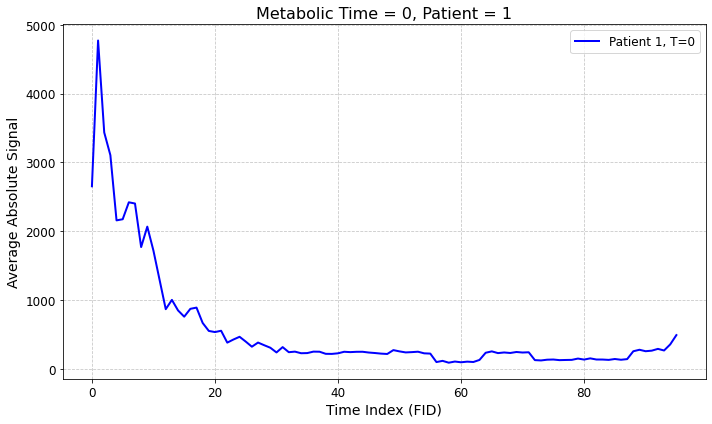

In [5]:
T = 0          # Metabolic time index
Patient = 1    # Patient index

Ground_Truth_abs = np.abs(Ground_Truth)
Patient_Set = Ground_Truth_abs[..., T, Patient]
Signal = []
for i in range(96):
    current_slice = Patient_Set[:, :, :, i]
    mean_signal = np.mean(current_slice)
    Signal.append(mean_signal)
Signal = np.array(Signal)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(96), Signal, color='blue', linewidth=2, label=f"Patient {Patient}, T={T}")
ax.set_xlabel("Time Index (FID)", fontsize=14)
ax.set_ylabel("Average Absolute Signal", fontsize=14)
ax.set_title(f"Metabolic Time = {T}, Patient = {Patient}", fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

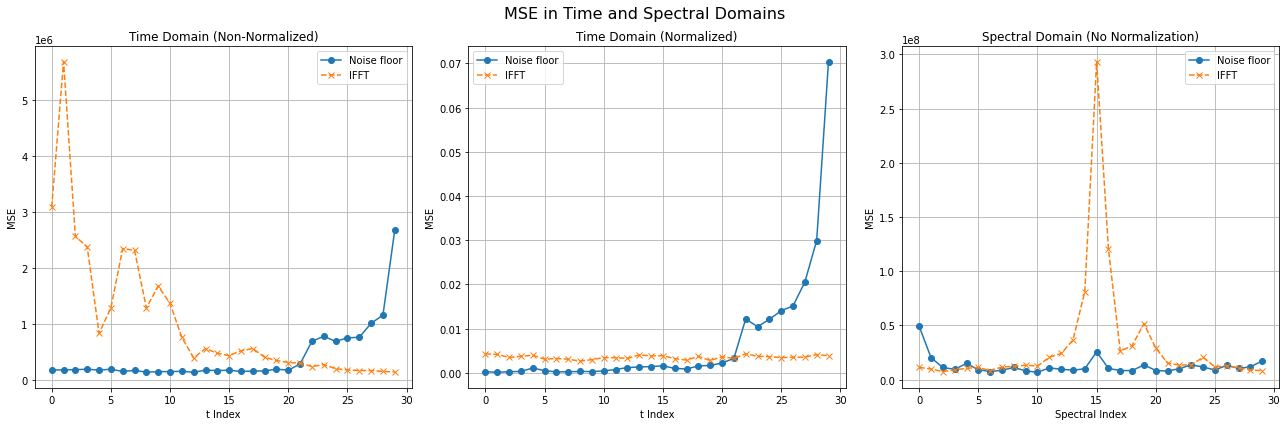

==== Model Output vs Ground Truth ====
Total MSE in image domain: 207869.96666666667
Normalized Total MSE in image domain: 0.003431388009428534
Total MSE in spectral domain: 6236099.17186441

==== Model Input vs Ground Truth ====
Total MSE in image domain: 525860.6
Normalized Total MSE in image domain: 0.0017749042837596717
Total MSE in spectral domain: 15775817.591722878


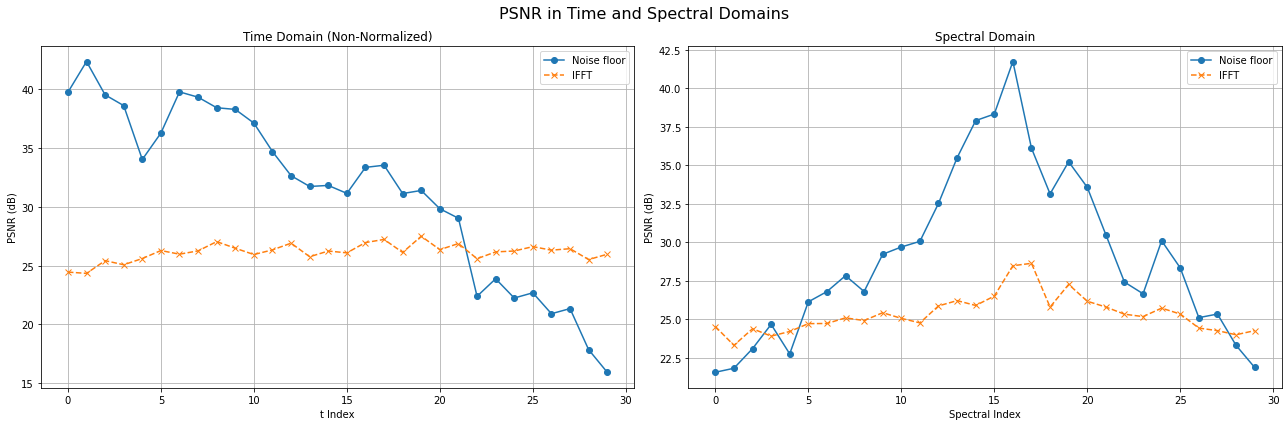

==== Model Output vs. Ground Truth ====
Average PSNR in image domain:    31.375329971313477
Average PSNR in frequency domain: 29.107349242037245

==== Model Input vs. Ground Truth ====
Average PSNR in image domain:    26.14333724975586
Average PSNR in frequency domain: 25.34851451218561


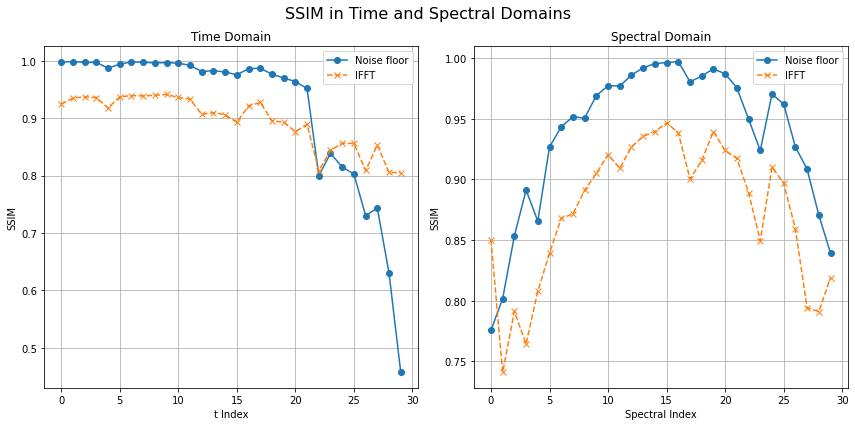

==== Model Output vs. Ground Truth ====
Average SSIM in image domain:    0.9171033347063592
Average SSIM in frequency domain: 0.9371959975679256

==== Model Input vs. Ground Truth ====
Average SSIM in image domain:    0.8955090789384186
Average SSIM in frequency domain: 0.8749514981861909


In [6]:
Patient = 5
label = "Noise floor"

_, _, norm_values_test = normalize_data_per_image_new(ground_truth_trancuated[..., Patient], Undersampled_Data_trancuated[..., Patient])

plot_general_statistics(ground_truth_trancuated_2[...,Patient], Undersampled_Data_trancuated[...,Patient], ground_truth_trancuated[...,Patient], trancuate_t, norm_values_test, label)
plot_general_statistics_PSNR(ground_truth_trancuated_2[...,Patient], Undersampled_Data_trancuated[...,Patient], ground_truth_trancuated[...,Patient], trancuate_t, norm_values_test, label)
plot_general_statistics_SSIM(ground_truth_trancuated_2[...,Patient], Undersampled_Data_trancuated[...,Patient], ground_truth_trancuated[...,Patient], trancuate_t, norm_values_test, label)

Optimal statistics

In [ ]:
Patient = 4
label = "GT + noise"

t = 0
T = 7

comparison_Plot_3D_vs_Ifft(ground_truth_trancuated_2[...,Patient], ground_truth_trancuated[...,Patient], Undersampled_Data_trancuated[...,Patient], t, T, domain="time", label = label)

## **Why are networks converging to IFFT, and how can it outperform the noise thresholds?**

### **Definitions**
- **k_space_ground_truth** := $k_{gt}$ *(measured k-space)*
- **k_gt** = signal + noise
- **k_gt_us** := $U \cdot k_{gt}$  
- **U: undersampling mask**
- **U'** := complementary mask, such that $U + U' = 1$

### **Goal of Network (NN)**  
- **Minimize**  
  $$ ||\text{NN}(k_{gt\_us}) - \text{IFFT}(k_{gt})||_2 $$  

Expanding step-by-step:

$$
||\text{NN}(k_{gt\_us}) - \text{IFFT}(k_{gt})||
$$

$$
= ||\text{NN}(U \cdot k_{gt}) - \text{IFFT}(k_{gt})||
$$

$$
= ||\text{NN}(U k_{gt}) - \text{IFFT}((U + U') k_{gt})||
$$

$$
= ||\text{NN}(U (\text{signal} + \text{noise})) - \text{IFFT}((U + U')(\text{signal} + \text{noise}))||
$$

$$
= ||\text{NN}(U (\text{signal} + \text{noise})) - \text{IFFT}(U (\text{signal} + \text{noise})) - \text{IFFT}(U' (\text{signal} + \text{noise}))||
$$

---

### **Key Takeaways**
- If the network converges to **IFFT**, it can **completely cancel the noise** in $U$.
- If **noise error** is much larger than the **undersampling error**, this approach is **optimal**.
- However, if the network **outperforms noise thresholds**, it is **overfitting** noise—exploiting noise patterns inherited from the ground truth.


# ***Alternative Method to compute noise***

Here I use the available masks to compute the noise (Take the average squared value outside the mask, mutiply with the number of points inside the mask, take the squareroot; this should give an estimate of the real noise as taken from the same measurement step of the FID). I then compute the ratio for the first 30 time steps with this method to the 2 norm of the last 30 time steps. If it is approximately one, the above noise estimation was realistic.

In [44]:
trancuate_t = 30
AF = 3

MASKS = np.load('../data/masks.npy')

### Load data and truncate
Ground_Truth_unmasked = np.load('../data/Low_Rank_8_P03-P08.npy')
Ground_Truth_unmasked_truncated = Ground_Truth_unmasked[:,:,:,:trancuate_t,:,:]

Ground_Truth_masked = np.load('../data/Low_Rank_8_P03-P08_masked.npy')
Ground_Truth_masked_truncated = Ground_Truth_masked[:,:,:,:trancuate_t,:,:]

Difference = Ground_Truth_unmasked_truncated - Ground_Truth_masked_truncated

# Initialize the estimate array with the shape (trancuate_t, 8, 6)
Estimate_MSE_mask = np.zeros((trancuate_t, 8, 6))

for i in range(trancuate_t):
    for j in range(8):
        for k in range(6):
            # Compute the mean squared noise over the spatial dimensions for the given volume,
            # then scale by the number of voxels in the corresponding mask.
            mse_value = np.mean(np.abs(Difference[:,:,:,i,j,k])**2)
            Estimate_MSE_mask[i, j, k] = mse_value

noise = Ground_Truth[:,:,:,96-trancuate_t:,:,:]    
Estimate_MSE_mask_tranacuated = np.zeros((trancuate_t, 8, 6))

for i in range(trancuate_t):
    for j in range(8):
        for k in range(6):
            # Compute the mean squared noise over the spatial dimensions for the given volume,
            # then scale by the number of voxels in the corresponding mask.
            mse_value = np.mean(np.abs(noise[:,:,:,i,j,k])**2)
            Estimate_MSE_mask_tranacuated[i, j, k] = mse_value


# ### Load undersampled data and trancuate
# Undersampled_Data = np.load(f'../data/Undersampled_Data_P03-P08_Low_Rank/Undersampled_possoin_3D_fixed_r0_AF_{AF}.npy')
# Undersampled_Data_trancuated = Undersampled_Data[:,:,:,:trancuate_t,:,:]

# #### extract noise, add it to ground truth to create noise equivalent ground truth
# noise = Ground_Truth[:,:,:,96-trancuate_t:,:,:]
# ground_truth_trancuated_2 = ground_truth_trancuated + noise

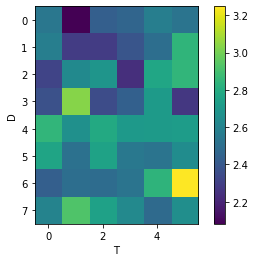

In [54]:
t = 0

# Display the image and capture the image object
im = plt.imshow(np.log10(Estimate_MSE[t, :, :] / Estimate_MSE_mask_tranacuated[t, :, :]))

# Set axis labels
plt.xlabel("T")
plt.ylabel("D")

# Add a colorbar for the image
plt.colorbar(im)

# Display the plot
plt.show()
